In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 6: Statistical Hypothesis Testing in ML Context

### Learning objectives

By the end of this lesson, you will be able to:

1. Convert a practical ML question into a statistical hypothesis test: define the estimand, the null, and what “evidence” means.
2. Distinguish **statistical significance** from **practical significance**, and always report effect sizes with uncertainty.
3. Select tests based on data type and experimental design: independent vs paired, categorical vs numeric, two groups vs many groups.
4. Diagnose common assumption failures (non-normality, heteroskedasticity, dependence) and choose robust alternatives.
5. Understand why “looking at the data many ways” inflates false positives, and apply multiple-testing corrections.
6. Compare ML models correctly: paired tests on cross-validation folds, and paired prediction tests such as McNemar’s test.
7. Communicate results as decisions: what changes, what risk remains, and what further validation is required.

## 1) Hypothesis testing as a decision tool in ML

In applied ML you rarely test hypotheses “for curiosity”. You test because you must **decide**:

- Should a feature be used, removed, or monitored?
- Should a model be deployed, rolled back, or shadow-tested?
- Should a product experiment be concluded or extended?
- Is a perceived improvement stable enough to invest engineering effort?

A good mental model is **decision under uncertainty**. A hypothesis test does not “prove truth”; it provides a controlled way to measure evidence under a baseline world.

### 1.1 From questions to estimands

A common failure is testing the wrong quantity. Before any test, define:

- **Population** (who/what the data represent)
- **Outcome** (what you measure)
- **Contrast** (difference in means, difference in proportions, association, etc.)
- **Time horizon** and **unit of analysis** (user-level, session-level, day-level)

Example: “Does model B improve conversion?”  
A minimal estimand could be the difference in conversion probabilities:

$$
\Delta = p_B - p_A.
$$

If your unit of analysis is “session” but the same user appears multiple times, independence is violated, and the test can be invalid.

### 1.2 What a p-value answers (and what it does not)

A p-value answers a *conditional* question:

> If $H_0$ were true, what is the probability of observing data (or a statistic) as extreme as we did?

It does **not** answer:

- “What is the probability that $H_0$ is true?”
- “What is the probability the result replicates?”
- “How large is the effect?”

This is why ML reporting should include effect sizes and confidence intervals, not only p-values.

## 2) Core mechanics: hypotheses, test statistics, and error rates

### 2.1 Null and alternative

- $H_0$ is the baseline claim: “no difference”, “no association”, “no improvement”.
- $H_1$ encodes the directional or non-directional alternative.

Common examples in ML:

- Feature relevance (univariate): $H_0$: feature $X$ is independent of label $Y$.
- A/B test: $H_0$: $p_B = p_A$.
- Model comparison: $H_0$: expected metric difference is zero.

### 2.2 Test statistics and reference distributions

You compute a statistic $T(\text{data})$. Under $H_0$, $T$ has a known or approximated distribution:

- t-distribution for t-tests
- chi-square distribution for contingency tables
- normal approximation for large-sample proportion tests
- permutation distribution when you shuffle labels

### 2.3 Type I, Type II, power

- Type I error (false positive): reject $H_0$ when it is true. Controlled at level $\alpha$.
- Type II error (false negative): fail to reject $H_0$ when $H_1$ is true. Probability $\beta$.
- Power: $1-\beta$.

In ML language:

- Type I: “We ship a change that is not truly better” or “we declare a noisy feature important”.
- Type II: “We miss a real improvement” or “we discard a feature that genuinely helps”.

### 2.4 Statistical vs practical significance

With very large datasets, tiny effects can become statistically significant. A disciplined workflow separates:

- Evidence that effect $\ne 0$ (significance)
- Whether the effect is large enough to matter (impact)

A practical habit: always report a confidence interval for the effect, e.g. for a mean difference $\Delta$:

$$
\Delta \in [\Delta_{\text{lo}}, \Delta_{\text{hi}}]
$$

and interpret what that interval means for decisions.

## 3) Choosing the right test: a practitioner’s map

Many ML mistakes come from using a test that does not match the data generating process. The key dimensions:

1. **Outcome type:** numeric vs categorical
2. **Number of groups:** two vs many
3. **Design:** independent vs paired / repeated measures
4. **Assumptions:** normality, equal variances, independence
5. **Goal:** difference in means, difference in medians, association, calibration, etc.

### 3.1 Quick selection table

| Question type | Typical data | Common tests | Notes |
|---|---|---|---|
| Difference in means (2 groups) | numeric outcome + 2 groups | Welch t-test | robust to unequal variances |
| Difference in medians / shifts | numeric outcome + 2 groups | Mann–Whitney U | tests ranks; not “mean” |
| Many groups (numeric outcome) | numeric + K groups | ANOVA / Kruskal–Wallis | follow with post-hoc + correction |
| Categorical association | two categorical variables | Chi-square / Fisher exact | Fisher for small counts |
| Correlation | two numeric variables | Pearson / Spearman | Spearman for monotonic / outliers |
| Paired numeric comparison | same units measured twice | paired t-test / Wilcoxon | pairing is essential |
| Paired classifier comparison | same examples, two models | McNemar / paired bootstrap | focuses on discordant errors |
| Compare metrics across folds | CV folds | paired t-test (with caution) | folds are not fully independent |

This lesson will implement several of these with concrete datasets.

### 3.2 A note on “test after model selection”

If you choose a model after searching many options, then run a statistical test “as if” you pre-specified everything, the p-value is often optimistic. In ML, this is one reason we prefer:

- nested CV
- held-out test sets used once
- pre-registered evaluation plans (in experiments)

## 4) Diagnostics and robustness: assumptions you must take seriously

A hypothesis test is only as good as its assumptions. In ML, the most common violations are:

1. **Dependence:** repeated measurements per user, time series autocorrelation, grouped data.
2. **Distribution shape:** heavy tails, skew, outliers.
3. **Heteroskedasticity:** variance changes with covariates or across groups.
4. **Selection bias:** you tested what you already suspected after exploring many plots and features.

### 4.1 Independence

Many tests assume independent observations. If your dataset includes multiple rows per entity (customer, device, listing, etc.), treat it as grouped data. Remedies include:

- aggregate per entity (if appropriate)
- use cluster-robust standard errors (in regression)
- use grouped resampling / block bootstrap
- use mixed / hierarchical models (more advanced)

### 4.2 Normality (what needs to be normal?)

For many parametric tests, you do not need the raw feature to be normal; you need the sampling distribution of the test statistic to be well approximated. Practical steps:

- visualize distributions (histograms, QQ plots)
- test sensitivity with nonparametric and permutation tests
- report robust summaries (median, IQR) when distributions are extreme

### 4.3 Equal variances

The pooled-variance t-test assumes equal variances. Welch’s t-test relaxes that assumption. For regression, heteroskedasticity can break standard errors; robust SEs (HC3) often fix inference.

In the code, we will explicitly check normality and variance assumptions and see how results change under robust alternatives.

## 5) Setup: imports and utility helpers

We will implement several tests and supporting utilities:

- effect sizes (Cohen’s $d$)
- bootstrap confidence intervals
- permutation tests for two-sample differences
- multiple-testing correction

Then we will apply them to multiple datasets:

- `cognitive.csv` (two-sample comparison + covariate adjustment)
- `drug200.csv` (chi-square + McNemar)
- `diabetes.csv` (multiple testing across features + model comparison)
- `diamonds.csv` (correlation + permutation)
- `house-prices.csv` (regression inference + robust SEs)

In [2]:
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.stats.power import TTestIndPower

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)

def cohen_d(x, y):
    # Cohen's d for two independent samples (pooled SD)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    nx, ny = len(x), len(y)
    sx2, sy2 = x.var(ddof=1), y.var(ddof=1)
    s_pooled = np.sqrt(((nx - 1) * sx2 + (ny - 1) * sy2) / (nx + ny - 2))
    return (x.mean() - y.mean()) / s_pooled

def hedges_g(x, y):
    # Hedges' g: small-sample corrected Cohen's d
    d = cohen_d(x, y)
    nx, ny = len(x), len(y)
    df = nx + ny - 2
    J = 1 - (3 / (4*df - 1))
    return J * d

def bootstrap_ci(data, stat_fn, n_boot=5000, ci=0.95, random_state=42):
    # percentile bootstrap CI for a statistic
    rng = np.random.default_rng(random_state)
    data = np.asarray(data)
    stats_boot = []
    n = len(data)
    for _ in range(n_boot):
        sample = data[rng.integers(0, n, size=n)]
        stats_boot.append(stat_fn(sample))
    stats_boot = np.array(stats_boot)
    alpha = 1 - ci
    lo = np.quantile(stats_boot, alpha / 2)
    hi = np.quantile(stats_boot, 1 - alpha / 2)
    return lo, hi

def permutation_test_two_sample(x, y, stat_fn=np.mean, n_perm=20000, alternative="two-sided", random_state=42):
    # permutation test for difference in stat_fn (default mean)
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    y = np.asarray(y)
    obs = stat_fn(x) - stat_fn(y)
    pooled = np.concatenate([x, y])
    n_x = len(x)

    more_extreme = 0
    for _ in range(n_perm):
        rng.shuffle(pooled)
        x_perm = pooled[:n_x]
        y_perm = pooled[n_x:]
        diff = stat_fn(x_perm) - stat_fn(y_perm)

        if alternative == "two-sided":
            if abs(diff) >= abs(obs):
                more_extreme += 1
        elif alternative == "greater":
            if diff >= obs:
                more_extreme += 1
        elif alternative == "less":
            if diff <= obs:
                more_extreme += 1
        else:
            raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    p = (more_extreme + 1) / (n_perm + 1)  # add-one smoothing
    return obs, p

def qq_plot(x, title):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    plt.figure()
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(title)
    plt.show()

## 6) Example 1 — Two-sample comparison on `cognitive.csv`

**Question:** Do `kid_score` values differ between children whose mothers finished high school (`mom_hs=yes`) vs not (`mom_hs=no`)?

### 6.1 Hypotheses

Let $\mu_{\text{yes}}$ and $\mu_{\text{no}}$ be the population means of `kid_score` in the two groups.

- $H_0: \mu_{\text{yes}} - \mu_{\text{no}} = 0$
- $H_1: \mu_{\text{yes}} - \mu_{\text{no}} \ne 0$

### 6.2 Plan

1. EDA: group sizes, missingness, histograms.
2. Assumption checks: QQ plots, Shapiro–Wilk (with caution), Levene test for variances.
3. Welch t-test + effect size (Cohen’s $d$ and Hedges’ $g$) + bootstrap CI.
4. Robust alternatives: Mann–Whitney U and a permutation test for mean difference.
5. (ML-relevant extension) Adjust for covariates using regression and interpret the coefficient on `mom_hs`.

We will implement all steps and then discuss what the numbers mean for ML decisions.

In [3]:
path_cog = "../../../Datasets/Regression/cognitive.csv"
df_cog = pd.read_csv(path_cog)
df_cog.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


Missing values per column:
kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

Group sizes:
mom_hs
yes    341
no      93
Name: count, dtype: int64

Summary (mom_hs=yes):
 count    341.000000
mean      89.319648
std       19.049483
min       38.000000
25%       77.000000
50%       92.000000
75%      103.000000
max      144.000000
Name: kid_score, dtype: float64

Summary (mom_hs=no):
 count     93.000000
mean      77.548387
std       22.573800
min       20.000000
25%       58.000000
50%       80.000000
75%       95.000000
max      136.000000
Name: kid_score, dtype: float64


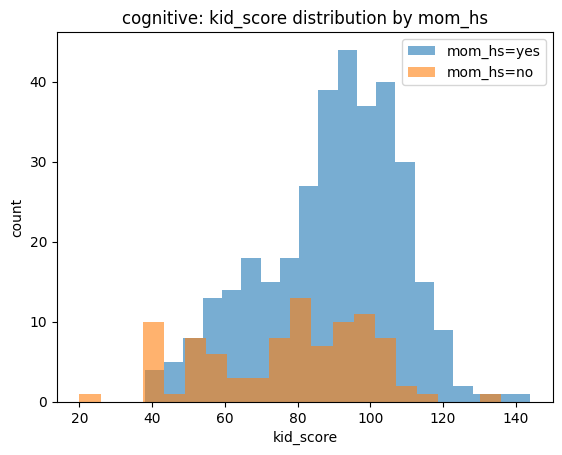

In [4]:
df_cog["mom_hs"] = df_cog["mom_hs"].astype(str).str.lower().str.strip()

print("Missing values per column:")
print(df_cog.isna().sum())
print("\nGroup sizes:")
print(df_cog["mom_hs"].value_counts(dropna=False))

x_yes = df_cog.loc[df_cog["mom_hs"] == "yes", "kid_score"].dropna().astype(float)
x_no  = df_cog.loc[df_cog["mom_hs"] == "no",  "kid_score"].dropna().astype(float)

print("\nSummary (mom_hs=yes):\n", x_yes.describe())
print("\nSummary (mom_hs=no):\n", x_no.describe())

plt.figure()
plt.hist(x_yes, bins=20, alpha=0.6, label="mom_hs=yes")
plt.hist(x_no,  bins=20, alpha=0.6, label="mom_hs=no")
plt.title("cognitive: kid_score distribution by mom_hs")
plt.xlabel("kid_score")
plt.ylabel("count")
plt.legend()
plt.show()

### 6.3 Assumption checks (diagnostics, not “pass/fail”)

Diagnostics help you judge robustness, but they should not be treated as hard gates.

- **QQ plots** show deviations from normality and heavy tails.
- **Shapiro–Wilk** can be overly sensitive for large samples, and underpowered for small samples. Treat it as one signal.
- **Levene** checks whether group variances are similar.

In many real ML datasets, distributions are not exactly normal. That does not automatically invalidate a t-test, especially with moderate sample sizes, but it motivates:

- Welch’s t-test (variance-robust)
- confirming with permutation / nonparametric tests
- focusing on effect sizes and CIs

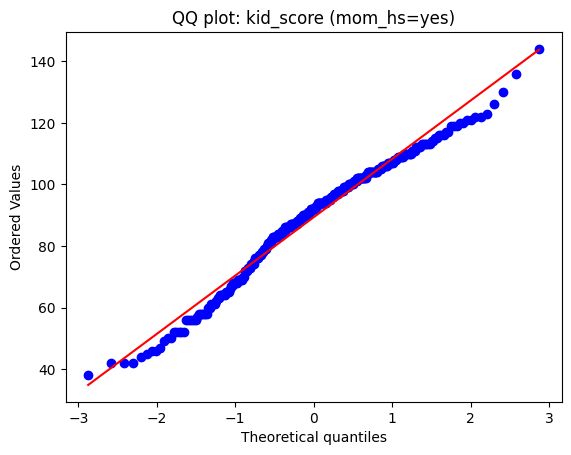

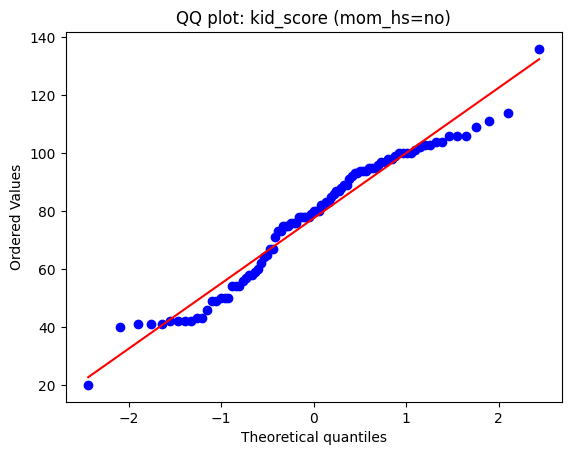

Shapiro–Wilk (yes): ShapiroResult(statistic=np.float64(0.9780986173689007), pvalue=np.float64(4.679620721386232e-05))
Shapiro–Wilk (no) : ShapiroResult(statistic=np.float64(0.9641688891021278), pvalue=np.float64(0.011815735859881342))
Levene stat=5.855, p-value=0.015948


In [5]:
qq_plot(x_yes, "QQ plot: kid_score (mom_hs=yes)")
qq_plot(x_no,  "QQ plot: kid_score (mom_hs=no)")

# Shapiro–Wilk (note: interpret with caution)
sh_yes = stats.shapiro(x_yes.sample(min(len(x_yes), 500), random_state=42) if len(x_yes) > 500 else x_yes)
sh_no  = stats.shapiro(x_no.sample(min(len(x_no), 500), random_state=42)  if len(x_no)  > 500 else x_no)
print("Shapiro–Wilk (yes):", sh_yes)
print("Shapiro–Wilk (no) :", sh_no)

# Levene test for equal variances
lev_stat, lev_p = stats.levene(x_yes, x_no, center="median")
print(f"Levene stat={lev_stat:.3f}, p-value={lev_p:.6f}")

### 6.4 Welch t-test, effect size, and uncertainty

We will compute:

- Welch t-test p-value (evidence against equal means under assumptions)
- mean difference $\Delta = \bar{x}_{\text{yes}} - \bar{x}_{\text{no}}$
- Cohen’s $d$ (standardized effect) and Hedges’ $g$ (small-sample corrected)
- bootstrap CI for $\Delta$

In ML, the effect size is often the most informative number: it tells you “how big” the shift is relative to within-group variability.

Mean difference (yes - no): 11.771
Welch t-statistic: 4.602
p-value: 0.000010
Cohen's d: 0.593
Hedges' g: 0.592
Bootstrap 95% CI for mean difference: [6.911, 16.766]


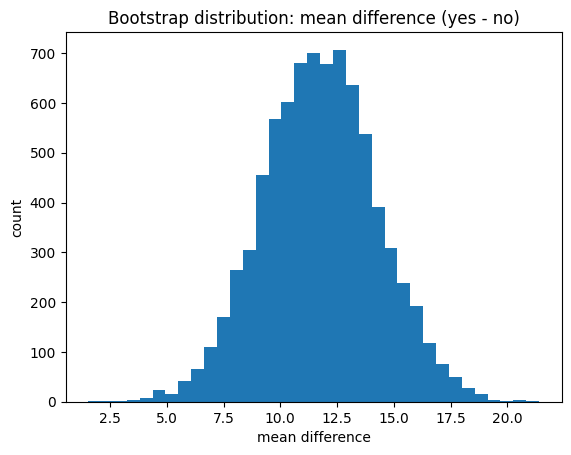

In [6]:
t_stat, p_val = stats.ttest_ind(x_yes, x_no, equal_var=False)
mean_diff = x_yes.mean() - x_no.mean()
d = cohen_d(x_yes, x_no)
g = hedges_g(x_yes, x_no)

print(f"Mean difference (yes - no): {mean_diff:.3f}")
print(f"Welch t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.6f}")
print(f"Cohen's d: {d:.3f}")
print(f"Hedges' g: {g:.3f}")

# Bootstrap CI for mean difference
rng = np.random.default_rng(42)
n_boot = 8000
boot_diffs = []
x_yes_arr = x_yes.to_numpy()
x_no_arr = x_no.to_numpy()
for _ in range(n_boot):
    s1 = x_yes_arr[rng.integers(0, len(x_yes_arr), size=len(x_yes_arr))]
    s2 = x_no_arr[rng.integers(0, len(x_no_arr), size=len(x_no_arr))]
    boot_diffs.append(s1.mean() - s2.mean())
boot_diffs = np.array(boot_diffs)

ci_lo, ci_hi = np.quantile(boot_diffs, [0.025, 0.975])
print(f"Bootstrap 95% CI for mean difference: [{ci_lo:.3f}, {ci_hi:.3f}]")

plt.figure()
plt.hist(boot_diffs, bins=35)
plt.title("Bootstrap distribution: mean difference (yes - no)")
plt.xlabel("mean difference")
plt.ylabel("count")
plt.show()

### 6.5 Power thinking (why “non-significant” is often inconclusive)

A non-significant p-value does **not** mean “no effect”. It can mean:

- effect is small
- sample size is small
- variance is large
- test assumptions are violated

Power analysis connects effect size, sample size, and $\alpha$. For a two-sample t-test, a common planning question is:

> For a target effect size $d^\*$ and desired power (e.g., 0.8), how many samples do we need per group?

We will estimate the implied power from the observed effect size (as a rough diagnostic) and compute required sample sizes for several target effects.

In [7]:
analysis = TTestIndPower()

# observed standardized effect (Cohen's d)
d_obs = abs(d)

# approximate power given group sizes
power_est = analysis.power(effect_size=d_obs, nobs1=len(x_yes), ratio=len(x_no)/len(x_yes), alpha=0.05, alternative="two-sided")
print(f"Approx power at observed |d|={d_obs:.3f}: {power_est:.3f}")

# required n per group for various target effect sizes
for d_target in [0.2, 0.3, 0.5, 0.8]:
    n_req = analysis.solve_power(effect_size=d_target, power=0.8, alpha=0.05, ratio=1.0, alternative="two-sided")
    print(f"Target d={d_target:.1f} -> required n per group for power=0.8: {np.ceil(n_req):.0f}")

Approx power at observed |d|=0.593: 0.999
Target d=0.2 -> required n per group for power=0.8: 394
Target d=0.3 -> required n per group for power=0.8: 176
Target d=0.5 -> required n per group for power=0.8: 64
Target d=0.8 -> required n per group for power=0.8: 26


### 6.6 Robust alternatives: Mann–Whitney U and permutation tests

- Mann–Whitney U tests whether values from one group tend to be larger than the other (rank-based).
- Permutation test for mean difference directly simulates the null distribution under label exchangeability.

These are useful cross-checks: if conclusions diverge, investigate distribution shape and outliers.

In [8]:
u_stat, p_u = stats.mannwhitneyu(x_yes, x_no, alternative="two-sided")
print(f"Mann–Whitney U: {u_stat:.1f}, p-value: {p_u:.6f}")

obs_diff, p_perm = permutation_test_two_sample(x_yes, x_no, stat_fn=np.mean, n_perm=30000, alternative="two-sided", random_state=42)
print(f"Permutation test (mean diff): obs={obs_diff:.3f}, p-value={p_perm:.6f}")

Mann–Whitney U: 20682.5, p-value: 0.000007
Permutation test (mean diff): obs=11.771, p-value=0.000033


### 6.7 Covariate adjustment: regression as hypothesis testing

Group comparisons can be confounded. In `cognitive.csv`, mother education (`mom_hs`) may correlate with mother IQ (`mom_iq`), age, or work status. A regression model can estimate the adjusted association:

$$
\text{kid\_score} = \beta_0 + \beta_1 \cdot \mathbb{1}(\text{mom\_hs=yes}) + \beta_2 \cdot \text{mom\_iq} + \beta_3 \cdot \text{mom\_age} + \cdots + \varepsilon.
$$

The hypothesis test for $\beta_1$ is:

- $H_0: \beta_1 = 0$
- $H_1: \beta_1 \ne 0$

This connects directly to ML feature analysis: “Does this attribute add predictive signal after controlling for other variables?”

In [9]:
# clean and fit an OLS regression with covariates
df_cog2 = df_cog.copy()
df_cog2["mom_hs_yes"] = (df_cog2["mom_hs"] == "yes").astype(int)

# ensure numeric
for c in ["kid_score", "mom_iq", "mom_age"]:
    df_cog2[c] = pd.to_numeric(df_cog2[c], errors="coerce")

# mom_work is yes/no; include as categorical
df_cog2["mom_work"] = df_cog2["mom_work"].astype(str).str.lower().str.strip()

reg = smf.ols("kid_score ~ mom_hs_yes + mom_iq + mom_age + C(mom_work)", data=df_cog2).fit()
print(reg.summary())

reg_robust = reg.get_robustcov_results(cov_type="HC3")
print("\nRobust (HC3) SE summary:")
print(reg_robust.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     29.74
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           7.51e-22
Time:                        17:45:32   Log-Likelihood:                -1871.2
No. Observations:                 434   AIC:                             3752.
Df Residuals:                     429   BIC:                             3773.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             19.5924      9

## 7) Example 2 — A/B style test for proportions (synthetic but realistic)

Many ML teams interpret online experiments through the lens of hypothesis testing. Suppose:

- Variant A: $x_A$ conversions out of $n_A$ trials
- Variant B: $x_B$ conversions out of $n_B$ trials

We test:

- $H_0: p_A = p_B$
- $H_1: p_A \ne p_B$

A common large-sample test is the two-proportion z-test. We will simulate an A/B test, compute p-values, and report an estimated lift and confidence interval.

This section is synthetic because your repository datasets are not explicitly A/B logs; the goal is to show a production-relevant pattern.

In [10]:
rng = np.random.default_rng(7)

# simulate conversion counts
n_A, n_B = 8000, 8000
p_A_true, p_B_true = 0.080, 0.085  # small lift
x_A = rng.binomial(n_A, p_A_true)
x_B = rng.binomial(n_B, p_B_true)

print(f"Observed: A {x_A}/{n_A} = {x_A/n_A:.4f}, B {x_B}/{n_B} = {x_B/n_B:.4f}")

count = np.array([x_A, x_B])
nobs = np.array([n_A, n_B])

z_stat, p_ab = proportions_ztest(count, nobs, alternative="two-sided")
print(f"Two-proportion z-test: z={z_stat:.3f}, p-value={p_ab:.6f}")

# estimate lift and a Wald-style CI for difference in proportions
pA_hat, pB_hat = x_A/n_A, x_B/n_B
diff_hat = pB_hat - pA_hat
se = np.sqrt(pA_hat*(1-pA_hat)/n_A + pB_hat*(1-pB_hat)/n_B)
ci_lo, ci_hi = diff_hat - 1.96*se, diff_hat + 1.96*se
print(f"Estimated lift (pB - pA): {diff_hat:.5f}")
print(f"Approx 95% CI for lift: [{ci_lo:.5f}, {ci_hi:.5f}]")

Observed: A 639/8000 = 0.0799, B 658/8000 = 0.0823
Two-proportion z-test: z=-0.550, p-value=0.582078
Estimated lift (pB - pA): 0.00238
Approx 95% CI for lift: [-0.00608, 0.01083]


### 7.1 Sequential peeking warning (why repeated testing inflates false positives)

In real A/B tests, teams often check metrics daily and stop early. If you repeatedly test until you see significance, your Type I error can be much larger than $\alpha$. This is the same “multiple comparisons” problem over time.

Solutions include:

- pre-defining a fixed horizon and reading the result once
- sequential testing methods (e.g., alpha spending)
- Bayesian monitoring (different framework)
- always using practical thresholds (minimum detectable effect) plus post-hoc validation

We will demonstrate the peeking problem with a simple simulation: run many A/B experiments under no effect and repeatedly test each day.

In [11]:
def peeking_false_positive_rate(n_sims=300, days=14, per_day=500, p_true=0.08, alpha=0.05, random_state=0):
    rng = np.random.default_rng(random_state)
    fp = 0
    for _ in range(n_sims):
        # under null: pA == pB
        stop = False
        xA = xB = 0
        nA = nB = 0
        for _day in range(days):
            xA += rng.binomial(per_day, p_true)
            xB += rng.binomial(per_day, p_true)
            nA += per_day
            nB += per_day
            z, p = proportions_ztest([xA, xB], [nA, nB], alternative="two-sided")
            if p < alpha:
                stop = True
                break
        if stop:
            fp += 1
    return fp / n_sims

rate = peeking_false_positive_rate(n_sims=400, days=14, per_day=600, p_true=0.08, alpha=0.05, random_state=42)
print(f"False positive rate with daily peeking (null true): {rate:.3f}")

False positive rate with daily peeking (null true): 0.240


## 8) Example 3 — Categorical association on `drug200.csv`

We test whether `Drug` is independent of `BP` (blood pressure category).

- $H_0$: `Drug` and `BP` are independent.
- $H_1$: they are associated.

We use the chi-square test of independence, then quantify strength with Cramér’s $V$ and inspect standardized residuals to see which cells drive the association.

In [12]:
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [13]:
ct = pd.crosstab(df_drug["BP"], df_drug["Drug"])
ct

Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,38,23,16,0,0
LOW,30,0,0,16,18
NORMAL,23,0,0,0,36


In [14]:
chi2, p, dof, expected = stats.chi2_contingency(ct.values)
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

print(f"Chi-square statistic: {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.6f}")
expected_df

Chi-square statistic: 143.233
Degrees of freedom: 8
p-value: 0.000000


Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,35.035,8.855,6.16,6.16,20.79
LOW,29.120,7.360,5.12,5.12,17.28
NORMAL,26.845,6.785,4.72,4.72,15.93


In [15]:
n = ct.values.sum()
r_, c_ = ct.shape
cramers_v = np.sqrt(chi2 / (n * (min(r_ - 1, c_ - 1))))
print(f"Cramér's V: {cramers_v:.3f}")

observed = ct.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, index=ct.index, columns=ct.columns)
residuals_df

Cramér's V: 0.598


Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,0.500926,4.753447,3.964649,-2.481935,-4.559605
LOW,0.163075,-2.712932,-2.262742,4.808326,0.173205
NORMAL,-0.742104,-2.604803,-2.172556,-2.172556,5.028512


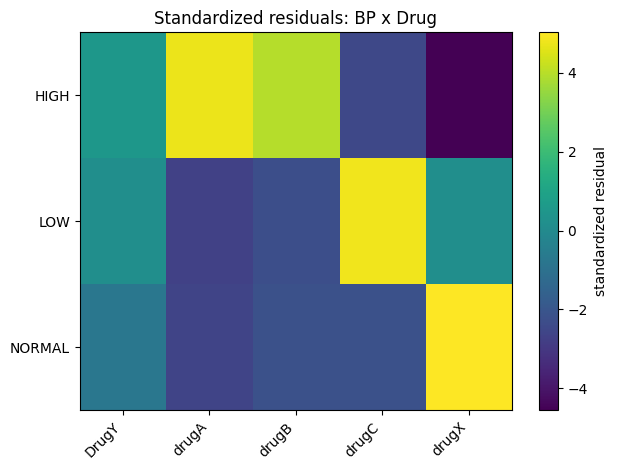

In [16]:
plt.figure()
plt.imshow(residuals, aspect="auto")
plt.colorbar(label="standardized residual")
plt.xticks(range(len(ct.columns)), ct.columns, rotation=45, ha="right")
plt.yticks(range(len(ct.index)), ct.index)
plt.title("Standardized residuals: BP x Drug")
plt.tight_layout()
plt.show()

### 8.1 Fisher exact idea for “small” 2x2 slices

If you reduce the table to a 2x2 (e.g., `BP == HIGH` vs others, `Drug == DrugY` vs others), you can use Fisher’s exact test, which is accurate for small counts.

We will create a 2x2 table and compare Fisher-style intuition with chi-square thinking.

In [17]:
# Build a 2x2 slice: HIGH vs NOT_HIGH, DrugY vs NOT_DrugY
bp_high = (df_drug["BP"].astype(str).str.upper() == "HIGH")
drug_y = (df_drug["Drug"].astype(str).str.upper() == "DRUGY")

table_2x2 = pd.crosstab(bp_high, drug_y)
table_2x2.index = ["BP_NOT_HIGH", "BP_HIGH"]
table_2x2.columns = ["NOT_DrugY", "DrugY"]
table_2x2

,NOT_DrugY,DrugY
BP_NOT_HIGH,70,53
BP_HIGH,39,38


In [18]:
oddsratio, p_fisher = stats.fisher_exact(table_2x2.values)
print("Fisher exact odds ratio:", oddsratio)
print("Fisher exact p-value:", p_fisher)

Fisher exact odds ratio: 1.2868892114175132
Fisher exact p-value: 0.4657971071575304


## 9) Example 4 — Multiple testing in EDA on `diabetes.csv`

A very common EDA pattern is:

- run univariate tests for many features
- rank by p-value
- interpret “top features”

This is dangerous without correction. If you test 20 independent null features at $\alpha=0.05$, you expect about 1 false positive on average.

We will:

1. Run Welch t-tests for each numeric feature between classes.
2. Compute effect sizes and BH-adjusted p-values (FDR control).
3. Visualize raw vs adjusted p-values and effect sizes.
4. Demonstrate “false discoveries” by permuting labels and repeating the same workflow.

In [19]:
path_diab = "../../../Datasets/Classification/diabetes.csv"
df_diab = pd.read_csv(path_diab)
df_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [20]:
df_diab["classification"] = df_diab["classification"].astype(str).str.strip()
num_cols = [c for c in df_diab.columns if c != "classification"]

group_a = df_diab[df_diab["classification"] == "Diabetic"]
group_b = df_diab[df_diab["classification"] == "Non-Diabetic"]

rows = []
for c in num_cols:
    x1 = pd.to_numeric(group_a[c], errors="coerce").dropna()
    x2 = pd.to_numeric(group_b[c], errors="coerce").dropna()
    t, p_ = stats.ttest_ind(x1, x2, equal_var=False)
    diff = x1.mean() - x2.mean()
    d_ = cohen_d(x1, x2)
    rows.append((c, diff, d_, t, p_, len(x1), len(x2)))

res_df = pd.DataFrame(rows, columns=["feature", "mean_diff(Diabetic-Non)", "cohen_d", "t_stat", "p_value", "n_diab", "n_non"])
res_df = res_df.sort_values("p_value")

rej, p_adj, _, _ = multipletests(res_df["p_value"].values, alpha=0.05, method="fdr_bh")
res_df["p_adj_bh"] = p_adj
res_df["reject_fdr_0.05"] = rej
res_df

,feature,mean_diff(Diabetic-Non),cohen_d,t_stat,p_value,n_diab,n_non,p_adj_bh,reject_fdr_0.05
1,Glucose,31.277463,1.105307,13.751537,2.644161e-36,268,500,2.115329e-35,True
5,BMI,4.838337,0.641366,8.619317,6.566238e-17,268,500,2.626495e-16,True
7,Age,5.877164,0.514245,6.920738,1.201513e-11,268,500,3.204033e-11,True
0,Pregnancies,1.567672,0.476827,5.906961,6.821926e-09,268,500,1.364385e-08,True
6,DiabetesPedigreeFunction,0.120766,0.369885,4.576812,6.100481e-06,268,500,9.760770e-06,True
4,Insulin,31.543821,0.275896,3.300895,1.046929e-03,268,500,1.395905e-03,True
3,SkinThickness,2.500179,0.157066,1.970579,4.935586e-02,268,500,5.640670e-02,False
2,BloodPressure,2.640627,0.136626,1.713087,8.735425e-02,268,500,8.735425e-02,False


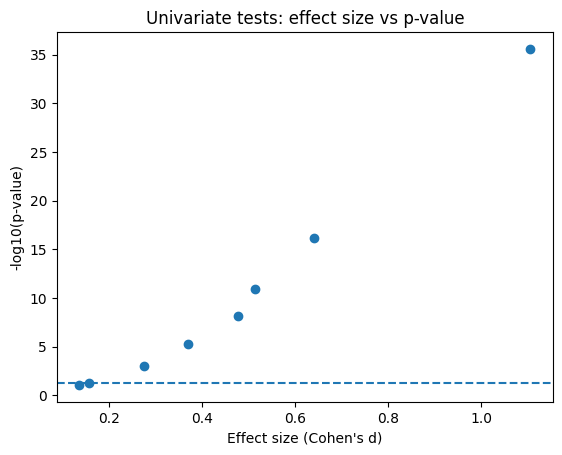

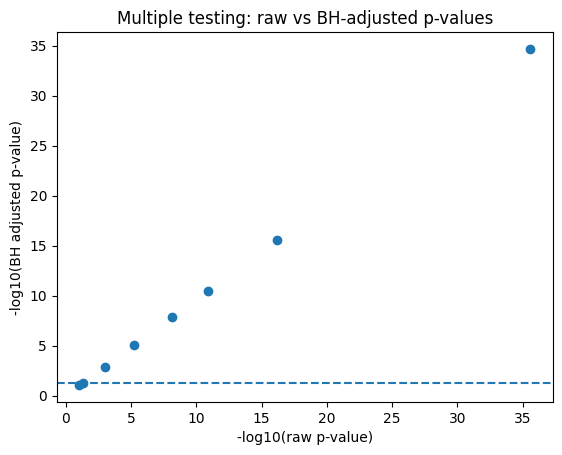

In [21]:
plt.figure()
plt.scatter(res_df["cohen_d"], -np.log10(res_df["p_value"]))
plt.axhline(-np.log10(0.05), linestyle="--")
plt.xlabel("Effect size (Cohen's d)")
plt.ylabel("-log10(p-value)")
plt.title("Univariate tests: effect size vs p-value")
plt.show()

plt.figure()
plt.scatter(-np.log10(res_df["p_value"]), -np.log10(res_df["p_adj_bh"]))
plt.xlabel("-log10(raw p-value)")
plt.ylabel("-log10(BH adjusted p-value)")
plt.title("Multiple testing: raw vs BH-adjusted p-values")
plt.axhline(-np.log10(0.05), linestyle="--")
plt.show()

### 9.1 Permutation-based sanity check: how often do we “discover” something under no signal?

To illustrate the multiple testing problem, we will:

- randomly shuffle labels (destroying real associations)
- re-run the same feature tests
- count how many “significant” features appear

If you see frequent “discoveries” under shuffled labels, you must treat uncorrected EDA p-values as a ranking heuristic, not a proof.

Under shuffled labels:
Avg #raw significant features: 0.412
Avg #BH significant features: 0.084


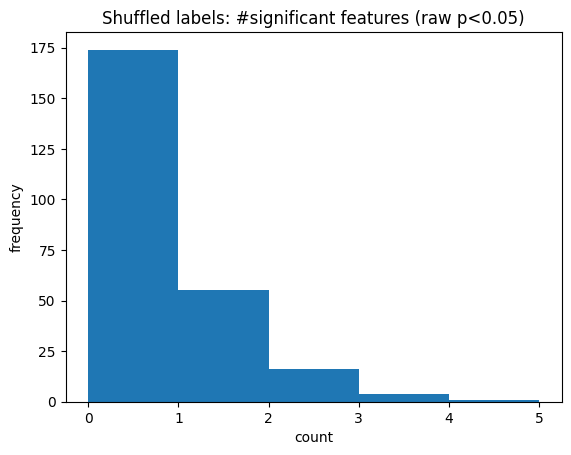

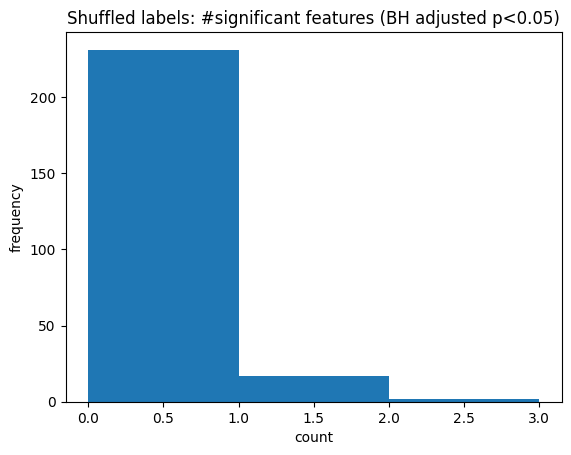

In [22]:
rng = np.random.default_rng(42)

def count_significant_under_shuffle(df, n_rep=200, alpha=0.05):
    y = df["classification"].to_numpy()
    X = df.drop(columns=["classification"])
    num_cols = X.columns.tolist()
    counts_raw = []
    counts_bh = []
    for _ in range(n_rep):
        y_shuf = rng.permutation(y)
        # run tests
        pvals = []
        for c in num_cols:
            x1 = pd.to_numeric(X.loc[y_shuf == "Diabetic", c], errors="coerce").dropna()
            x2 = pd.to_numeric(X.loc[y_shuf == "Non-Diabetic", c], errors="coerce").dropna()
            t, p_ = stats.ttest_ind(x1, x2, equal_var=False)
            pvals.append(p_)
        pvals = np.array(pvals)
        counts_raw.append(np.sum(pvals < alpha))
        _, p_adj, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
        counts_bh.append(np.sum(p_adj < alpha))
    return np.array(counts_raw), np.array(counts_bh)

raw_counts, bh_counts = count_significant_under_shuffle(df_diab, n_rep=250, alpha=0.05)
print("Under shuffled labels:")
print("Avg #raw significant features:", raw_counts.mean())
print("Avg #BH significant features:", bh_counts.mean())

plt.figure()
plt.hist(raw_counts, bins=range(raw_counts.min(), raw_counts.max()+2))
plt.title("Shuffled labels: #significant features (raw p<0.05)")
plt.xlabel("count")
plt.ylabel("frequency")
plt.show()

plt.figure()
plt.hist(bh_counts, bins=range(bh_counts.min(), bh_counts.max()+2))
plt.title("Shuffled labels: #significant features (BH adjusted p<0.05)")
plt.xlabel("count")
plt.ylabel("frequency")
plt.show()

## 10) Example 5 — Correlation tests on `diamonds.csv`

We examine the relationship between `carat` and `price`.

- Pearson correlation tests linear association and is sensitive to outliers and nonlinear monotonic patterns.
- Spearman correlation uses ranks and is more robust to outliers and monotonic nonlinearities.

We will compute both, visualize scatter, and also run a permutation test for the correlation as a robustness check.

In [23]:
path_diam = "../../../Datasets/Regression/diamonds.csv"
df_diam = pd.read_csv(path_diam)
df_diam.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Pearson r: 0.9216, p-value: 0.000e+00
Spearman rho: 0.9629, p-value: 0.000e+00


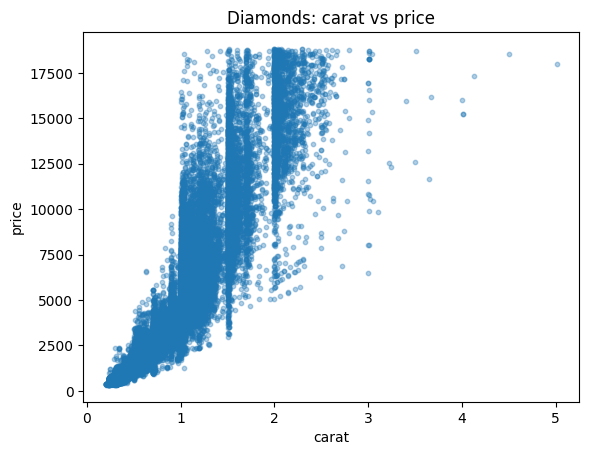

In [24]:
x = pd.to_numeric(df_diam["carat"], errors="coerce").dropna()
y = pd.to_numeric(df_diam.loc[x.index, "price"], errors="coerce").dropna()

pearson_r, pearson_p = stats.pearsonr(x, y)
spearman_r, spearman_p = stats.spearmanr(x, y)

print(f"Pearson r: {pearson_r:.4f}, p-value: {pearson_p:.3e}")
print(f"Spearman rho: {spearman_r:.4f}, p-value: {spearman_p:.3e}")

plt.figure()
plt.scatter(x, y, s=10, alpha=0.35)
plt.xlabel("carat")
plt.ylabel("price")
plt.title("Diamonds: carat vs price")
plt.show()

In [25]:
# Fisher transform CI for Pearson r
n = len(x)
z = np.arctanh(pearson_r)
se = 1 / np.sqrt(n - 3)
z_lo, z_hi = z - 1.96 * se, z + 1.96 * se
r_lo, r_hi = np.tanh([z_lo, z_hi])
print(f"Approx 95% CI for Pearson r: [{r_lo:.4f}, {r_hi:.4f}]")

# Permutation test for Pearson correlation
rng = np.random.default_rng(42)
n_perm = 15000
obs = pearson_r
more_extreme = 0
y_arr = y.to_numpy()
x_arr = x.to_numpy()

for _ in range(n_perm):
    y_perm = rng.permutation(y_arr)
    r_perm, _ = stats.pearsonr(x_arr, y_perm)
    if abs(r_perm) >= abs(obs):
        more_extreme += 1
p_perm = (more_extreme + 1) / (n_perm + 1)
print(f"Permutation p-value for Pearson r: {p_perm:.6f}")

Approx 95% CI for Pearson r: [0.9203, 0.9229]
Permutation p-value for Pearson r: 0.000067


## 11) Example 6 — Regression inference on `house-prices.csv`

Regression is a natural bridge between statistics and ML. Even if your goal is prediction, regression inference can answer questions like:

- “Is `SqFt` associated with `Price` after controlling for other covariates?”
- “Are effects stable, or are standard errors inflated by heteroskedasticity?”

We will fit an OLS model and compare:

- classical standard errors
- robust HC3 standard errors

We will also test for heteroskedasticity using the Breusch–Pagan test and visualize residual patterns.

In [26]:
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)

df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [27]:
df_house["Brick"] = df_house["Brick"].astype(str).str.strip()
df_house["Neighborhood"] = df_house["Neighborhood"].astype(str).str.strip()

model = smf.ols("Price ~ SqFt + Bedrooms + Bathrooms + Offers + C(Brick) + C(Neighborhood)", data=df_house).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     113.3
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           8.25e-50
Time:                        17:48:54   Log-Likelihood:                -1356.7
No. Observations:                 128   AIC:                             2729.
Df Residuals:                     120   BIC:                             2752.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [28]:
model_robust = model.get_robustcov_results(cov_type="HC3")
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     111.1
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           2.36e-49
Time:                        17:48:54   Log-Likelihood:                -1356.7
No. Observations:                 128   AIC:                             2729.
Df Residuals:                     120   BIC:                             2752.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

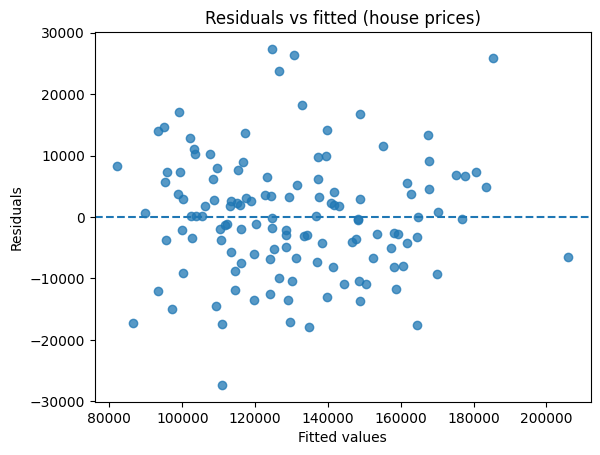

Breusch–Pagan LM stat: 5.843, p-value: 0.558155
Breusch–Pagan F stat: 0.820, p-value: 0.572467


In [29]:
fitted = model.fittedvalues
resid = model.resid

plt.figure()
plt.scatter(fitted, resid, alpha=0.75)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted (house prices)")
plt.show()

bp_stat, bp_p, f_stat, f_p = het_breuschpagan(resid, model.model.exog)
print(f"Breusch–Pagan LM stat: {bp_stat:.3f}, p-value: {bp_p:.6f}")
print(f"Breusch–Pagan F stat: {f_stat:.3f}, p-value: {f_p:.6f}")

## 12) Example 7 — Comparing ML models on cross-validation folds (diabetes)

A frequent ML claim is “model B is better than model A”. To evaluate this statistically, a common approach is:

1. Run K-fold CV and compute a metric for each fold.
2. Compute fold-wise differences.
3. Apply a paired test on differences.

Caution: CV folds share training data, so fold results are not perfectly independent. The paired t-test is still widely used as a practical heuristic, but you should interpret p-values conservatively and always report effect sizes and uncertainty.

We will compare Logistic Regression vs Random Forest using Accuracy and ROC-AUC.

In [30]:
df = df_diab.copy()
y_bin = (df["classification"] == "Diabetic").astype(int)
X = df.drop(columns=["classification"])

num_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_features)],
    remainder="drop"
)

logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=350, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_lr, acc_rf = [], []
auc_lr, auc_rf = [], []

for train_idx, test_idx in cv.split(X, y_bin):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

    logreg.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    pred_lr = logreg.predict(X_test)
    pred_rf = rf.predict(X_test)

    proba_lr = logreg.predict_proba(X_test)[:, 1]
    proba_rf = rf.predict_proba(X_test)[:, 1]

    acc_lr.append(accuracy_score(y_test, pred_lr))
    acc_rf.append(accuracy_score(y_test, pred_rf))
    auc_lr.append(roc_auc_score(y_test, proba_lr))
    auc_rf.append(roc_auc_score(y_test, proba_rf))

acc_lr = np.array(acc_lr)
acc_rf = np.array(acc_rf)
auc_lr = np.array(auc_lr)
auc_rf = np.array(auc_rf)

print("Accuracy per fold")
print("LogReg:", acc_lr)
print("RF    :", acc_rf)
print("Mean difference (RF - LR):", (acc_rf - acc_lr).mean())

print("\nROC-AUC per fold")
print("LogReg:", auc_lr)
print("RF    :", auc_rf)
print("Mean difference (RF - LR):", (auc_rf - auc_lr).mean())

Accuracy per fold
LogReg: [0.77922078 0.79220779 0.78571429 0.76470588 0.75163399]
RF    : [0.7987013  0.77272727 0.77922078 0.75816993 0.74509804]
Mean difference (RF - LR): -0.003913080383668621

ROC-AUC per fold
LogReg: [0.81685185 0.86925926 0.84111111 0.80886792 0.81584906]
RF    : [0.85407407 0.84444444 0.82916667 0.81377358 0.79339623]
Mean difference (RF - LR): -0.003416841369671575


In [31]:
def paired_tests(a, b, name="metric"):
    d = b - a  # difference (b - a)
    t, p_t = stats.ttest_rel(b, a)

    try:
        w_stat, p_w = stats.wilcoxon(d)
    except ValueError as e:
        w_stat, p_w = np.nan, np.nan
        print(f"Wilcoxon warning for {name}: {e}")

    lo, hi = bootstrap_ci(d, stat_fn=np.mean, n_boot=12000, ci=0.95, random_state=42)

    print(f"\n=== {name} ===")
    print("Differences (b - a):", d)
    print(f"Paired t-test: t={t:.3f}, p={p_t:.6f}")
    print(f"Wilcoxon signed-rank: W={w_stat}, p={p_w}")
    print(f"Bootstrap 95% CI for mean difference: [{lo:.4f}, {hi:.4f}]")
    print(f"Mean difference: {d.mean():.4f}, Std of differences: {d.std(ddof=1):.4f}")

paired_tests(acc_lr, acc_rf, name="Accuracy (RF vs LR)")
paired_tests(auc_lr, auc_rf, name="ROC-AUC (RF vs LR)")


=== Accuracy (RF vs LR) ===
Differences (b - a): [ 0.01948052 -0.01948052 -0.00649351 -0.00653595 -0.00653595]
Paired t-test: t=-0.615, p=0.571895
Wilcoxon signed-rank: W=4.0, p=0.4375
Bootstrap 95% CI for mean difference: [-0.0143, 0.0091]
Mean difference: -0.0039, Std of differences: 0.0142

=== ROC-AUC (RF vs LR) ===
Differences (b - a): [ 0.03722222 -0.02481481 -0.01194444  0.00490566 -0.02245283]
Paired t-test: t=-0.299, p=0.779911
Wilcoxon signed-rank: W=6.0, p=0.8125
Bootstrap 95% CI for mean difference: [-0.0213, 0.0184]
Mean difference: -0.0034, Std of differences: 0.0256


## 13) Example 8 — McNemar’s test on paired predictions (`drug200.csv`)

When two classifiers are evaluated on the **same test set**, their predictions are paired per example. Comparing their accuracies as if they were independent can be misleading.

McNemar’s test focuses on the **discordant pairs**:

- $n_{01}$: model A wrong, model B correct
- $n_{10}$: model A correct, model B wrong

Null hypothesis: $n_{01}$ and $n_{10}$ are equal in expectation (no difference in error rates).

We will train two models and apply McNemar’s test on the hold-out predictions.

In [32]:
df = df_drug.copy()

y = df["Drug"].astype(str)
X = df.drop(columns=["Drug"])

cat_cols = ["Sex", "BP", "Cholesterol"]
num_cols = ["Age", "Na_to_K"]

preprocess_drug = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", SimpleImputer(strategy="median"), num_cols)
    ],
    remainder="drop"
)

clf_a = Pipeline(steps=[
    ("preprocess", preprocess_drug),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=4))
])

clf_b = Pipeline(steps=[
    ("preprocess", preprocess_drug),
    ("model", GaussianNB())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf_a.fit(X_train, y_train)
clf_b.fit(X_train, y_train)

pred_a = clf_a.predict(X_test)
pred_b = clf_b.predict(X_test)

a_correct = (pred_a == y_test.to_numpy())
b_correct = (pred_b == y_test.to_numpy())

n01 = np.sum((~a_correct) & ( b_correct))
n10 = np.sum(( a_correct) & (~b_correct))
n00 = np.sum((~a_correct) & (~b_correct))
n11 = np.sum(( a_correct) & ( b_correct))

table = [[n11, n10],
         [n01, n00]]

print("McNemar 2x2 table (correctness):")
print(pd.DataFrame(table, index=["A correct", "A wrong?"], columns=["B correct", "B wrong?"]))

result = mcnemar(table, exact=False, correction=True)
print("\nMcNemar test statistic:", result.statistic)
print("p-value:", result.pvalue)
print(f"Discordant counts: n01 (A wrong, B correct)={n01}, n10 (A correct, B wrong)={n10}")

McNemar 2x2 table (correctness):
           B correct  B wrong?
A correct         38        11
A wrong?           1         0

McNemar test statistic: 6.75
p-value: 0.0093747684594349
Discordant counts: n01 (A wrong, B correct)=1, n10 (A correct, B wrong)=11


## 14) Reporting checklist for ML practitioners

A statistically responsible ML write-up should include:

1. **Decision context:** what action depends on this analysis?
2. **Estimand:** exactly what effect is being estimated (difference in means, lift, AUC difference, etc.).
3. **Design:** independent vs paired, grouped structure, time window, unit of analysis.
4. **Assumptions and diagnostics:** plots + tests used as signals.
5. **Test used and why:** include alternatives if assumptions are questionable.
6. **Effect size and uncertainty:** CI + effect size, not only p-value.
7. **Multiple comparisons control:** if you explored many hypotheses, report correction method.
8. **Stability checks:** sensitivity to outliers, alternative tests, or different time slices.
9. **Conclusion framed as decision:** what you will do, what risk remains.

### Practical rule-of-thumb

If you cannot explain how the test result changes a decision, you probably do not need the test; you need better problem formulation.

## 15) Exercises (do these with one dataset from your repo)

1. Pick a dataset with a binary label (e.g., `diabetes.csv` or `iris.csv` after mapping classes) and choose **three** numeric features.
   - Run univariate tests between classes.
   - Compute Cohen’s $d$ and BH-adjusted p-values.
   - Write one paragraph explaining which feature is most practically important and why.

2. Create a “peeking” simulation like Section 7.1 but for a metric that you care about (conversion, accuracy, etc.).
   - Estimate the false positive rate under repeated testing.

3. Model comparison:
   - Choose two models and one dataset.
   - Run K-fold CV and compute differences in a metric.
   - Report mean difference + bootstrap CI.
   - Explain whether the improvement is likely to matter in practice.

4. McNemar:
   - On a multiclass dataset, compare two classifiers on the same hold-out set.
   - Identify whether one model systematically corrects the other’s errors.